### Import libraries

In [1]:
from hashlib import md5
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import re
import requests
import tabula

### Data caching

The data retrieved from the remote sources is stored locally to speed up the processing.
<ul>
    <li><b>cache_data</b> activates the cache</li>
    <li><b>refresh_data</b> forces the refresh of the cached data</li>
</ul>

In [2]:
cache_data = True
refresh_cache = False

### Defining global pandas visualization options

In [3]:
pd.options.display.width = 1000
pd.options.display.max_colwidth = 199
pd.options.display.max_columns = None

### Retrieve the boroughs data

Read the boroughs data from https://de.m.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens and merging the income data from https://de.m.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens. Data is cleaned and put in a format that supports the analysis.

In [4]:
def get_boroughs(cache_data=True, refresh_cache=False):
    boroughs = None
    
    REMOTE_DISTRICTS ='https://de.m.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens'
    LOCAL_DATA_DISTRICTS = 'data/munich_boroughs.csv'
    
    REMOTE_INCOME = 'https://www.tz.de/muenchen/stadt/muenchen-einkommen-viertel-report-pro-kopf-1519197.html'
    LOCAL_INCOME = 'data/munich_income.csv'
    
    if os.path.exists(LOCAL_DATA_DISTRICTS) and cache_data and not refresh_cache :
        boroughs = pd.read_csv(LOCAL_DATA_DISTRICTS)
        
        boroughs = boroughs.astype(dtype={ 'BoroughID': 'int32' }) 
    else :
        # Import data of boroughs
        print("Importing borough data from " + REMOTE_DISTRICTS)
        tables = pd.read_html(REMOTE_DISTRICTS, thousands='.', decimal=',')
        boroughs = tables[0]
        
        boroughs.columns = ['BoroughID','Borough','Surface','Habitants','Density','Foreigners']
        
        boroughs.describe(include='all')
        
        #Total row is not relevant.
        boroughs.dropna(subset=['BoroughID'], inplace=True)
        
        print('{} NaN identified after data cleaning'.format(boroughs.isna().sum()))
        
        #Transform the ID to integers
        boroughs['BoroughID'] = boroughs['BoroughID'].astype('int32')
        
        print("Importing income data from " + REMOTE_INCOME)
        income_pc = pd.read_html(REMOTE_INCOME)[0]
        income_pc.columns = ['Borough','Income']
        
        #Data is cleaned to be used
        income_pc['Borough'] = income_pc['Borough'].apply(lambda x : x.replace(', ','-').strip())
        income_pc['Income'] = income_pc['Income'].apply(lambda x : x.replace('€','').strip()).astype('int32')
        
        #The name of the borough for the following two boroughs is wrong on the website. It is therefore renamed
        borough_corr = {
            'Obergiesing' : 'Obergiesing-Fasangarten',
            'Thalkirchen-Obersendling-Fürstenried-Forstenried-Solln' : 'Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln'
        }
        
        income_pc.replace({'Borough':borough_corr},inplace=True)
        
        boroughs = pd.merge(left=boroughs,right=income_pc,how='left',left_on='Borough',right_on='Borough')
        
        boroughs.info()
        
        #replace the NaN value of Sendling with the average
        boroughs['Income'].fillna(boroughs['Income'].mean().round(0),inplace = True)
        
        if cache_data or refresh_cache :
            boroughs.to_csv(LOCAL_DATA_DISTRICTS, index=False)
            income_pc.to_csv(LOCAL_INCOME, index=False)
    
    return boroughs

### Retrieve neighborhoods geographical data

Retrieve the postcodes belonging to each borough from https://www.muenchen.de/leben/service/postleitzahlen.html and the respective latitude and longitude of the centroid from https://www.suche-postleitzahl.org/download_v1/wgs84/mittel/plz-5stellig/geojson/points/plz-5stellig-centroid.geojson
Data is cleaned and prepared for further processing.

In [5]:
def get_neighborhoods(cache_data=True, refresh_cache=False):
    zip_boroughs = None
    
    REMOTE_ZIP = 'https://www.muenchen.de/leben/service/postleitzahlen.html'
    REMOTE_ZIP_CENTROIDS = 'https://www.suche-postleitzahl.org/download_v1/wgs84/mittel/plz-5stellig/geojson/points/plz-5stellig-centroid.geojson'
    
    LOCAL_ZIP = 'data/munich_zip.csv'
    LOCAL_ZIP_CENTROIDS = 'data/munich_zip_centroids.geojson'
    
    if os.path.exists(LOCAL_ZIP) and cache_data and not refresh_cache :
        print('Importing the neighborhoods geographical data from local cache: ' + LOCAL_ZIP)
        zip_boroughs = pd.read_csv(LOCAL_ZIP)
        
        zip_boroughs = zip_boroughs.astype(dtype={ 'Postcode': 'str', 'BoroughID': 'int32' }) 
    else :
        print("Importing neighborhoods data from " + REMOTE_ZIP)
        tables = pd.read_html(REMOTE_ZIP)
        zip_boroughs = tables[0]
        
        zip_boroughs = pd.DataFrame(tables[0].Postleitzahl.str.split(',').tolist(), index=tables[0].Stadtteil).stack()
        
        zip_boroughs = zip_boroughs.reset_index([0, 'Stadtteil'])
        zip_boroughs.columns = ['Borough','Postcode']
        
        #The name of the borough for the following two boroughs is wrong on the website. It is therefore renamed
        borough_corr = {
            'Obergiesing' : 'Obergiesing-Fasangarten',
            'Thalkirchen-Obersendling-Fürstenried-Forstenried-Solln' : 'Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln'
        }
        
        zip_boroughs.replace({'Borough':borough_corr},inplace=True)
        
        # Some ZIP code strings contain blanks, which make the join of the datasets impossible.          
        zip_boroughs['Postcode'] = zip_boroughs['Postcode'].str.strip()
        
        # Download the centroids GeoJSON
        zip_centroids = None
        
        if os.path.exists(LOCAL_ZIP_CENTROIDS) and cache_data and not refresh_cache :
            with open(LOCAL_ZIP_CENTROIDS, 'r') as f:
                zip_centroids = json.load(f)
        else :
            print("Reading neighborhoods coordinates from " + REMOTE_ZIP_CENTROIDS)
            json_data = requests.get(REMOTE_ZIP_CENTROIDS)         
                        
            
            with open(LOCAL_ZIP_CENTROIDS, 'w') as f:
                f.write(json_data.text)
                f.flush()
                os.fsync(f.fileno())  
            
            zip_centroids = json_data.json()
        
        # Create a dataframe that contains zip codes, latitude and longitude
        zip_centroids_df = json_normalize(zip_centroids['features'])
        
        coords = pd.DataFrame(zip_centroids_df['geometry.coordinates'].values.tolist())
        
        zip_centroids_df = pd.concat([zip_centroids_df.loc[:, ['properties.plz','properties.qkm']], coords], axis=1)
        
        zip_centroids_df.columns=['Postcode','Surface','Lon','Lat']
        
        coords = None
        
        zip_boroughs = pd.merge(left=zip_boroughs,right=zip_centroids_df, how='left', left_on='Postcode', right_on='Postcode')
        
        boroughs = get_boroughs(cache_data, refresh_cache)
        
        d_map = boroughs[['Borough','BoroughID']].set_index('Borough').T.to_dict('record')[0]
        
        zip_boroughs.insert(0, 'BoroughID', zip_boroughs['Borough']) 
        zip_boroughs.replace({'BoroughID': d_map}, inplace = True)
        zip_boroughs['BoroughID'] = zip_boroughs['BoroughID'].astype('int32') 
        
    if cache_data or refresh_cache :
        zip_boroughs.to_csv(LOCAL_ZIP, index=False)
    
    return zip_boroughs

### Retrieve demographic data

Retrieve the demographic data from the city demographic report 2019. The data includes the number of habitants, their age group (<6, 6-14, 15-44, 45-64, >65), and the number of households per number of households (1 to 5). The data is extracted from the PDF report using the tabula library. Table area and columns width have been calculated using the tabula tool and reported as constant. The data is also cleaned and stored in a data frame for further processing.

In [6]:
def get_demographics(refresh_cache=False):

    REMOTE_MUC19 = 'https://www.muenchen.de/rathaus/dam/jcr:1c6b38f7-5e7e-4114-bde8-5ca74200c561/LHM-StatTB_2019.pdf'
    LOCAL_MUC19 = 'data/LHM-StatTB_2019.pdf'
    LOCAL_MUC19_CSV = 'data/munich_demograhics.csv'

    if os.path.exists(LOCAL_MUC19_CSV) and not refresh_cache :
        print('Importing demographic data from local cache: ' + LOCAL_MUC19_CSV)
        demographics = pd.read_csv(LOCAL_MUC19_CSV)
    else :
        if not os.path.exists(LOCAL_MUC19) or refresh_cache :
            print("Downloading demographic report from " + REMOTE_MUC19)
            pdf_data = requests.get(REMOTE_MUC19)         
              
            if pdf_data.status_code == '200':                
                with open(LOCAL_MUC19, 'wb') as f:
                    f.write(pdf_data.content)
                    os.fsync(f.fileno())
            else :
                pdf_data.raise_for_status()
                    
        # Extract the number of habitants for the borough from the PDF
        demographics = pd.DataFrame([], columns=['Habitants','Age','BoroughID'])
        
        borough_start_page = 20 # Page in which the data of the Borough 1 is reported
        borough_page_offset = 7 # number of pages between the same table
        
        #Creates the list of pages in which the data is contained
        borough_pages = []
        
        #Process even pages first
        for borough_id in range(0,25,2) :
            borough_pages.append(borough_start_page+borough_id*borough_page_offset)
        
        #Select even pages
        borough_pages_str = ','.join(str(x) for x in borough_pages)

        # The Area and the columns have been calculated using the tabula tool
        borough_table_area = (65.39,23.02,246.81,259.86)
        borough_table_columns = (23.02,62.05,89.37,116.69,144.01,171.33,198.65,225.97)
        
        print('Parsing even pages [{}] in {}'.format(borough_pages_str, LOCAL_MUC19))
        # Read even pages first
        tables = None
        tables = tabula.read_pdf(LOCAL_MUC19,pages=borough_pages_str, area=borough_table_area,stream=True,columns=borough_table_columns, multiple_tables=True)
        
        # Read odd pages
        
        even_odd_offset = 13.4
        borough_table_columns_odd = ( x + even_odd_offset for x in borough_table_columns)
        borough_table_area_odd = (65.39,24.75+even_odd_offset,246.81,251.68+even_odd_offset)
        borough_pages.clear()
        
        #Process even pages first
        for borough_id in range(1,25,2) :
            borough_pages.append(borough_start_page+borough_id*borough_page_offset)
        
        borough_pages_str = ','.join(str(x) for x in borough_pages) 
        
        print('Parsing odd pages [{}] in {}'.format(borough_pages_str, LOCAL_MUC19))
        
        tables_odd = tabula.read_pdf(LOCAL_MUC19,pages=borough_pages_str, area=borough_table_area_odd,stream=True,columns=borough_table_columns_odd, multiple_tables=True)

        #Merge even and odd tables
        for i,v in enumerate(tables_odd):
            tables.insert(2*i+1,v)

        # Repeat the task for the 25 boroughs
        for borough_id in range(0,25) :
            # Select the column year (1) and total habitants (8)
            df = tables[borough_id]
            
            #Create a temporary DataFrame to clean the data
            print('Process borough {}'.format(borough_id))
            tmp = pd.concat( [df.iloc[2:22,[1,8]].reset_index(), df[2:22][1][::4].repeat(4).reset_index()[1]], axis =1 )
            tmp.columns = ['Index','Year','Habitants','Age']
            tmp['BoroughID'] = (borough_id+1)
            tmp.dropna(inplace=True)
            
            #Convert the Habitants in number
            tmp['Habitants'] = tmp['Habitants'].str.replace(' ','').astype('int32')
    
            # Merge the data in the demographics DataFrame. Select only the data of 2018
            demographics = demographics.append(tmp.loc[tmp['Year']=='2018',['Habitants','Age','BoroughID']])
    
        #Check that the right number of elements have been selected
        print('Check that the right number of elements have been selected')
        demographics.info()
        demographics.BoroughID.value_counts()
        
        #Cleaning Age
        print('Cleaning the age column')
        demographics.Age.unique()
        
        #Standardize values
        age_ranges = { 'unter 6' : 'Age_0_5',
            '6 bis 14' : 'Age_6_14',
            '15 bis 44' : 'Age_15_44',
            '45 bis 64' : 'Age_45_64',
            '65 J. u. älter' : 'Age_65_999',
            '65 J. u. ä' : 'Age_65_999',
            '65 J. u. älte': 'Age_65_999'
        }
        
        demographics.replace({"Age": age_ranges}, inplace=True)
        
        # Merge demographic data
        demographics = demographics.pivot(index='BoroughID',columns='Age',values='Habitants')
        
        #Transforming columns in float
        demographics.loc[:,['Age' in x for x in demographics.columns]] = demographics.loc[:,['Age' in x for x in demographics.columns]].astype('int32')
        
        # Add hauseholds
        households_t1_page = 10
        households_t1_area = (62.28, 25, 304.09, 252.36)
        households_t1_columns = (25,35.61,132.97,162.67,190.99,219.31)
        
        tables = tabula.read_pdf(LOCAL_MUC19,pages=households_t1_page, area=households_t1_area,stream=True,columns=households_t1_columns, pandas_options={'header': None})
        
        #Correct helements in which the borough name is in 2 rows
        tables[1] = tables[1].fillna(method='ffill')
        
        #Create the households matrix
        households = pd.concat([tables[1], tables.loc[:,[4,6]].apply(lambda x : x.str.replace(' ',''))], axis=1)
        
        #Remove NA
        households.dropna(inplace = True)
        
        households_t2_page = 11
        househods_t2_area = (61.99,40.12,304.45,266.9)
        households_t2_columns = (40.12,67.48,94.84,122.2,149.56,176.92,204.28,231.64) 
        tables = tabula.read_pdf(LOCAL_MUC19,pages=households_t2_page, area=househods_t2_area,stream=True,columns=households_t2_columns, pandas_options={'header': None})
        
        households = pd.concat([households.reset_index(), tables.loc[:,[2,4,6]].apply(lambda x : x.str.replace(' ',''))], axis=1)
        
        households = households.iloc[:,1:]
        
        households.columns = ['BoroughID','1HH','2HH','3HH','4HH','5HH']
        households = households.astype('int32')
    
        #Merge the demographic information
        demographics = pd.merge(left=demographics,right=households, how='left', left_on='BoroughID', right_on='BoroughID')
        
        #Check data
        print('Check data for NaN')
        demographics.isna().sum()
        
        demographics.to_csv(LOCAL_MUC19_CSV, index=False)
    
    return demographics

### Retrieving Munich neighborhoods GeoJSON

Download the neighborhoods polygons from https://www.suche-postleitzahl.org/download_v1/wgs84/mittel/plz-5stellig/geojson/plz-5stellig.geojson. As the GeoJSON contains the Postcodes of the whole Germany, the data has to be filtered to select only the neighborhoods of interest.

In [7]:
def get_boroughs_polygons_geojson(nb=None, cache_data=True, refresh_cache=False):
    cache_key = ''
    zip_codes = nb['Postcode'].tolist() if not nb is None else None
    
    #Create a cache key
    if(not nb is None):
        zc_hash = md5()
        zc_hash.update(str(zip_codes.sort()).encode('utf-8'))
        cache_key = '_{}'.format(zc_hash.hexdigest())
    
    dp = None
    
    REMOTE_ZIP_POLY = 'https://www.suche-postleitzahl.org/download_v1/wgs84/mittel/plz-5stellig/geojson/plz-5stellig.geojson'
    LOCAL_BASE_ZIP_POLY = 'data/munich_zip_polygons.geojson'
    LOCAL_ZIP_POLY = 'data/munich_zip_polygons{}.geojson'.format(cache_key)
    
    if os.path.exists(LOCAL_ZIP_POLY) and cache_data and not refresh_cache :
        print('Reading cached data from {}'.format(LOCAL_ZIP_POLY))
        with open(LOCAL_ZIP_POLY, 'r') as f:
            dp = json.load(f)
    else :
        if LOCAL_BASE_ZIP_POLY != LOCAL_ZIP_POLY and os.path.exists(LOCAL_BASE_ZIP_POLY):
            print('Reading cached data from {}'.format(LOCAL_BASE_ZIP_POLY))
            with open(LOCAL_BASE_ZIP_POLY, 'r') as f:
                dp = json.load(f)        
        else:
            print("Downloading polygon data from " + REMOTE_ZIP_POLY)
            raw_data = requests.get(REMOTE_ZIP_POLY)         
              
            if raw_data.status_code == '200':                
                dp = raw_data.json()
                
                if cache_data :
                    # create a cache of the remote base data
                    with open(LOCAL_BASE_ZIP_POLY, 'w') as f:
                        json.dump(dp, f) 
                        f.flush()   
                        os.fsync(f.fileno())            
            else :
                raw_data.raise_for_status()
        
        if(not nb is None):
            # Filter the features limited to the Zip Codes of tnterest
            dp['features'] = [x for x in dp['features'] if x['properties']['plz'] in zip_codes]
        
            labels = nb[['Postcode','Borough']].set_index('Postcode').to_dict('index')
        
            for x in dp['features']:
                plz = x['properties']['plz']
                
                try :
                    x['properties']['note'] = '{}: {}'.format(plz, labels[plz]['Borough'])
                except:
                    x['properties']['note'] = '{}: {}'.format(plz, 'N/A')
        
            if cache_data :
                print('Writing cached data to {}'.format(LOCAL_ZIP_POLY))
                # create a cache of the remote base data
                with open(LOCAL_ZIP_POLY, 'w') as f:
                    json.dump(dp, f) 
                    f.flush()   
                    os.fsync(f.fileno())
        
    return dp

### Initial data exploration and features selection

In the following the boroughs data and the demographics one are merged to create a data frame that will be used to initially explore the data. Data will be transformed to add additional metrics that resulted relevant according to the problem analysis.

In [8]:
boroughs = get_boroughs(cache_data, refresh_cache)
boroughs.head()

Importing borough data from https://de.m.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens
BoroughID     0
Borough       0
Surface       0
Habitants     0
Density       0
Foreigners    0
dtype: int64 NaN identified after data cleaning
Importing income data from https://www.tz.de/muenchen/stadt/muenchen-einkommen-viertel-report-pro-kopf-1519197.html
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 7 columns):
BoroughID     25 non-null int32
Borough       25 non-null object
Surface       25 non-null float64
Habitants     25 non-null int64
Density       25 non-null int64
Foreigners    25 non-null float64
Income        24 non-null float64
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 1.5+ KB


,BoroughID,Borough,Surface,Habitants,Density,Foreigners,Income
0,1,Altstadt-Lehel,3.15,21100,6708,26.1,2000.0
1,2,Ludwigsvorstadt-Isarvorstadt,4.40,51644,11734,28.4,1800.0
2,3,Maxvorstadt,4.30,51402,11960,25.4,1700.0
3,4,Schwabing-West,4.36,68527,15706,22.7,1700.0
4,5,Au-Haidhausen,4.22,61356,14541,23.5,1700.0


In [9]:
demographics = get_demographics(refresh_cache)
demographics.head()

Parsing even pages [20,34,48,62,76,90,104,118,132,146,160,174,188] in data/LHM-StatTB_2019.pdf
Parsing odd pages [27,41,55,69,83,97,111,125,139,153,167,181] in data/LHM-StatTB_2019.pdf
Process borough 0
Process borough 1
Process borough 2
Process borough 3
Process borough 4
Process borough 5
Process borough 6
Process borough 7
Process borough 8
Process borough 9
Process borough 10
Process borough 11
Process borough 12
Process borough 13
Process borough 14
Process borough 15
Process borough 16
Process borough 17
Process borough 18
Process borough 19
Process borough 20
Process borough 21
Process borough 22
Process borough 23
Process borough 24
Check that the right number of elements have been selected
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 3 to 19
Data columns (total 3 columns):
Habitants    125 non-null object
Age          125 non-null object
BoroughID    125 non-null object
dtypes: object(3)
memory usage: 3.9+ KB
Cleaning the age column
Check data for NaN


,BoroughID,Age_0_5,Age_15_44,Age_45_64,Age_65_999,Age_6_14,1HH,2HH,3HH,4HH,5HH
0,1,1068,10074,5429,3432,1097,8138,2691,1014,648,212
1,2,2760,27656,12786,5807,2635,19962,6462,2456,1550,567
2,3,2403,29796,10928,6223,2052,21916,6428,2065,1331,465
3,4,3661,33562,15792,11507,4005,24501,9127,3352,2346,860
4,5,3759,29258,15887,8629,3823,21169,8070,3266,2258,790


In [10]:
boroughs = pd.merge(left=boroughs, right=demographics, how='left', on='BoroughID')
boroughs.sort_values(by='Density', ascending=False)

,BoroughID,Borough,Surface,Habitants,Density,Foreigners,Income,Age_0_5,Age_15_44,Age_45_64,Age_65_999,Age_6_14,1HH,2HH,3HH,4HH,5HH
3,4,Schwabing-West,4.36,68527,15706,22.7,1700.0,3661,33562,15792,11507,4005,24501,9127,3352,2346,860
4,5,Au-Haidhausen,4.22,61356,14541,23.5,1700.0,3759,29258,15887,8629,3823,21169,8070,3266,2258,790
7,8,Schwanthalerhöhe,2.07,29743,14367,33.5,1400.0,1613,14971,7531,3639,1989,10261,3818,1523,1107,429
2,3,Maxvorstadt,4.30,51402,11960,25.4,1700.0,2403,29796,10928,6223,2052,21916,6428,2065,1331,465
1,2,Ludwigsvorstadt-Isarvorstadt,4.40,51644,11734,28.4,1800.0,2760,27656,12786,5807,2635,19962,6462,2456,1550,567
24,25,Laim,5.29,56546,10698,28.5,1700.0,2966,25852,13867,10629,3232,19171,7922,2904,1917,739
5,6,Sendling,3.94,40983,10405,26.9,1646.0,2326,19899,10650,5827,2281,14690,5795,2151,1328,496
16,17,Obergiesing-Fasangarten,5.72,54256,9485,31.1,1600.0,3266,26063,13390,8172,3365,17587,7188,2960,1954,780
8,9,Neuhausen-Nymphenburg,12.91,98814,7651,24.3,1600.0,5964,44966,25037,16480,6367,31998,13449,5319,3720,1353
6,7,Sendling-Westpark,7.81,59643,7632,28.9,1650.0,3605,26609,14564,10800,4065,18078,8201,3260,2370,995


Check data to identify inconsistencies

In [11]:
print('Check the data for NaN')
boroughs.isna().sum()

Check the data for NaN


BoroughID     0
Borough       0
Surface       0
Habitants     0
Density       0
Foreigners    0
Income        0
Age_0_5       0
Age_15_44     0
Age_45_64     0
Age_65_999    0
Age_6_14      0
1HH           0
2HH           0
3HH           0
4HH           0
5HH           0
dtype: int64

In [12]:
boroughs.describe()

,BoroughID,Surface,Habitants,Density,Foreigners,Income,Age_0_5,Age_15_44,Age_45_64,Age_65_999,Age_6_14,1HH,2HH,3HH,4HH,5HH
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000,25.000000
mean,13.000000,12.428400,61688.440000,7288.080000,28.044000,1645.720000,3652.040000,27381.480000,15650.000000,10650.600000,4354.320000,17854.000000,8234.200000,3420.160000,2503.80000,1021.720000
std,7.359801,9.057945,22328.409576,4093.981303,4.347037,132.824295,1430.295409,9260.121666,5841.197566,4800.677877,2005.333071,6364.585447,3075.609194,1356.247018,1074.18535,510.492452
min,1.000000,2.070000,21100.000000,1404.000000,22.700000,1388.000000,1068.000000,10074.000000,5429.000000,3432.000000,1097.000000,6475.000000,2691.000000,1014.000000,648.00000,212.000000
25%,7.000000,4.400000,49898.000000,4523.000000,24.300000,1600.000000,2760.000000,20339.000000,11974.000000,7865.000000,3232.000000,13452.000000,6462.000000,2566.000000,1862.00000,668.000000
50%,13.000000,9.220000,56546.000000,6601.000000,27.400000,1667.000000,3399.000000,26609.000000,14173.000000,10629.000000,3904.000000,18190.000000,7861.000000,3101.000000,2324.00000,860.000000
75%,19.000000,17.760000,74625.000000,10405.000000,31.100000,1700.000000,4556.000000,33562.000000,18099.000000,11605.000000,5532.000000,21796.000000,9247.000000,4091.000000,3085.00000,1387.000000
max,25.000000,34.060000,116327.000000,15706.000000,40.800000,2000.000000,7036.000000,46463.000000,30320.000000,22937.000000,9571.000000,31998.000000,15931.000000,6865.000000,5075.00000,2501.000000


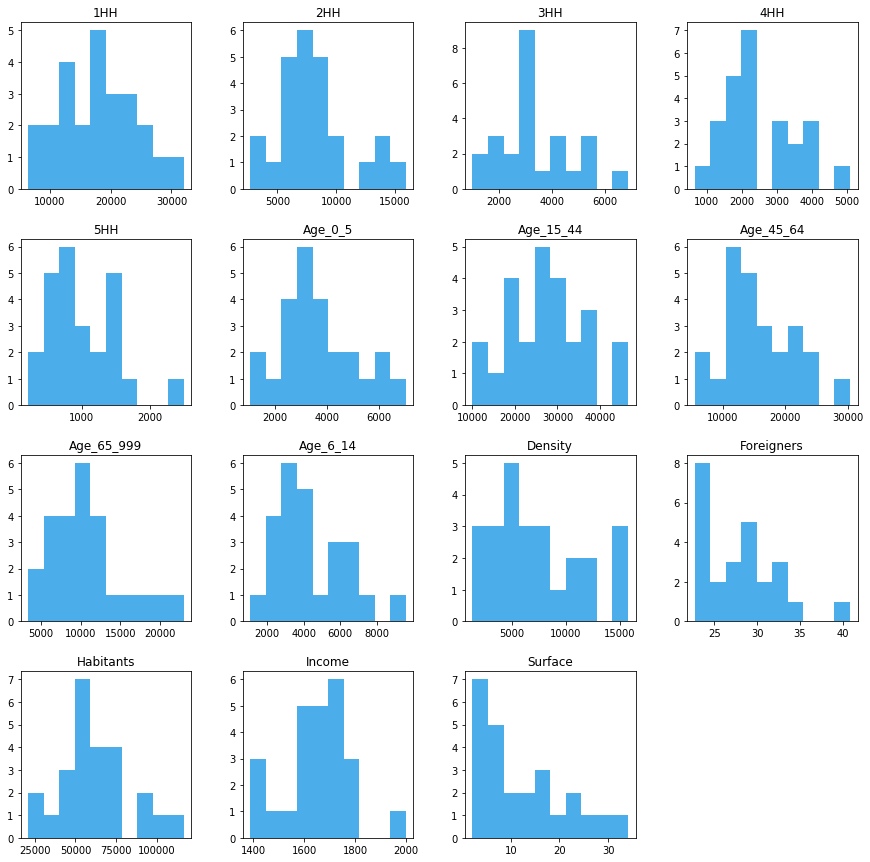

In [13]:
dm_hist = boroughs.loc[:,'Surface':].hist(layout=(4,4), figsize=(15,15), grid=False, color='#4BAEEA')

In [14]:
#Check data consistency households and Total age
dm = boroughs.copy()
dm['Age_Total'] = dm.loc[:,['Age' in x for x in dm.columns]].sum(axis=1)
print('{} inconsistencies on Age statistics identified'.format(dm[dm['Habitants']!=dm['Age_Total']].shape[0]))

0 inconsistencies on Age statistics identified


In [15]:
dm.head()

,BoroughID,Borough,Surface,Habitants,Density,Foreigners,Income,Age_0_5,Age_15_44,Age_45_64,Age_65_999,Age_6_14,1HH,2HH,3HH,4HH,5HH,Age_Total
0,1,Altstadt-Lehel,3.15,21100,6708,26.1,2000.0,1068,10074,5429,3432,1097,8138,2691,1014,648,212,21100
1,2,Ludwigsvorstadt-Isarvorstadt,4.40,51644,11734,28.4,1800.0,2760,27656,12786,5807,2635,19962,6462,2456,1550,567,51644
2,3,Maxvorstadt,4.30,51402,11960,25.4,1700.0,2403,29796,10928,6223,2052,21916,6428,2065,1331,465,51402
3,4,Schwabing-West,4.36,68527,15706,22.7,1700.0,3661,33562,15792,11507,4005,24501,9127,3352,2346,860,68527
4,5,Au-Haidhausen,4.22,61356,14541,23.5,1700.0,3759,29258,15887,8629,3823,21169,8070,3266,2258,790,61356


In [16]:
dm_corr = dm.loc[:,'Surface':].corr('pearson')

#The matrix is displayed as as heat map
dm_corr.style.background_gradient(cmap='coolwarm')

,Surface,Habitants,Density,Foreigners,Income,Age_0_5,Age_15_44,Age_45_64,Age_65_999,Age_6_14,1HH,2HH,3HH,4HH,5HH,Age_Total
Surface,1,0.451743,-0.811563,0.063684,-0.246137,0.558359,0.294438,0.486994,0.502732,0.650001,0.0139926,0.426801,0.568754,0.650973,0.690004,0.451743
Habitants,0.451743,1,-0.21183,0.0359529,-0.159227,0.981025,0.951084,0.986101,0.94331,0.912349,0.835712,0.991105,0.973473,0.925026,0.874458,1
Density,-0.811563,-0.21183,1,-0.0985305,0.0821511,-0.319341,-0.0113766,-0.274901,-0.344091,-0.453846,0.246913,-0.207833,-0.361974,-0.459169,-0.500218,-0.21183
Foreigners,0.063684,0.0359529,-0.0985305,1,-0.674512,0.0336645,0.0684258,-0.00564304,0.00940251,0.0542618,-0.0755217,-0.000529241,0.0454552,0.0155068,0.218175,0.0359529
Income,-0.246137,-0.159227,0.0821511,-0.674512,1,-0.188232,-0.135663,-0.151791,-0.136351,-0.243638,0.0252995,-0.138775,-0.209388,-0.219953,-0.34461,-0.159227
Age_0_5,0.558359,0.981025,-0.319341,0.0336645,-0.188232,1,0.896634,0.987096,0.935768,0.954135,0.74517,0.973067,0.989316,0.962454,0.918437,0.981025
Age_15_44,0.294438,0.951084,-0.0113766,0.0684258,-0.135663,0.896634,1,0.895826,0.816689,0.768083,0.931976,0.921636,0.861182,0.779717,0.739456,0.951084
Age_45_64,0.486994,0.986101,-0.274901,-0.00564304,-0.151791,0.987096,0.895826,1,0.950317,0.951167,0.767054,0.984049,0.991226,0.961351,0.902341,0.986101
Age_65_999,0.502732,0.94331,-0.344091,0.00940251,-0.136351,0.935768,0.816689,0.950317,1,0.902533,0.703274,0.968313,0.958635,0.92648,0.860594,0.94331
Age_6_14,0.650001,0.912349,-0.453846,0.0542618,-0.243638,0.954135,0.768083,0.951167,0.902533,1,0.552223,0.901083,0.9746,0.994505,0.978385,0.912349


To understand if the provided Pearson's correlations have statistical significance, the p-value is needed. Pandas does not provide native support for the statistical significance of the correlation, therefore scipy is used.

In [17]:
from scipy.stats import pearsonr

# This functiona calculates the p-value of the Pearson correlation
# using scipy.stat library
def pearson_corr_pvalue(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

# This function masks the Pearson correlation matrix marking with 1 star ('*')
# correlation values with p-value <0.1 (bad significance), with 2 stars
# p-value < 0.05 (mid significance), and 3 stars correlations with
# p-value < 0.01 (high significance)
def pearson_corr(df):
    df_corr = round(df.corr(method='pearson'),3)
    pvalues = pearson_corr_pvalue(df)
    
    m_pval_0_10 = df_corr.applymap(lambda x : '{}*'.format(x))
    m_pval_0_05 = df_corr.applymap(lambda x : '{}**'.format(x))
    m_pval_0_01 = df_corr.applymap(lambda x : '{}**'.format(x))
    
    df_corr = df_corr.mask(pvalues<=0.1,m_pval_0_10)
    df_corr = df_corr.mask(pvalues<=0.05,m_pval_0_05)
    df_corr = df_corr.mask(pvalues<=0.01,m_pval_0_01)    
    
    return df_corr

In [18]:
dm_corr2 = pearson_corr(dm.loc[:,'Surface':])
dm_corr2

,Surface,Habitants,Density,Foreigners,Income,Age_0_5,Age_15_44,Age_45_64,Age_65_999,Age_6_14,1HH,2HH,3HH,4HH,5HH,Age_Total
Surface,1.0**,0.452**,-0.812**,0.064,-0.246,0.558**,0.294,0.487**,0.503**,0.65**,0.014,0.427**,0.569**,0.651**,0.69**,0.452**
Habitants,0.452**,1.0**,-0.212,0.036,-0.159,0.981**,0.951**,0.986**,0.943**,0.912**,0.836**,0.991**,0.973**,0.925**,0.874**,1.0**
Density,-0.812**,-0.212,1.0**,-0.099,0.082,-0.319,-0.011,-0.275,-0.344*,-0.454**,0.247,-0.208,-0.362*,-0.459**,-0.5**,-0.212
Foreigners,0.064,0.036,-0.099,1.0**,-0.675**,0.034,0.068,-0.006,0.009,0.054,-0.076,-0.001,0.045,0.016,0.218,0.036
Income,-0.246,-0.159,0.082,-0.675**,1.0**,-0.188,-0.136,-0.152,-0.136,-0.244,0.025,-0.139,-0.209,-0.22,-0.345*,-0.159
Age_0_5,0.558**,0.981**,-0.319,0.034,-0.188,1.0**,0.897**,0.987**,0.936**,0.954**,0.745**,0.973**,0.989**,0.962**,0.918**,0.981**
Age_15_44,0.294,0.951**,-0.011,0.068,-0.136,0.897**,1.0**,0.896**,0.817**,0.768**,0.932**,0.922**,0.861**,0.78**,0.739**,0.951**
Age_45_64,0.487**,0.986**,-0.275,-0.006,-0.152,0.987**,0.896**,1.0**,0.95**,0.951**,0.767**,0.984**,0.991**,0.961**,0.902**,0.986**
Age_65_999,0.503**,0.943**,-0.344*,0.009,-0.136,0.936**,0.817**,0.95**,1.0**,0.903**,0.703**,0.968**,0.959**,0.926**,0.861**,0.943**
Age_6_14,0.65**,0.912**,-0.454**,0.054,-0.244,0.954**,0.768**,0.951**,0.903**,1.0**,0.552**,0.901**,0.975**,0.995**,0.978**,0.912**


All correlations calculated have mid to low statistical significance. Besides the strong correlation between the habitants and the number of households - which does not provide valuable information - it is to notice the moderate inverse correlation between the average income and the percentage of foreigners among the habitants of the borhoug. The distribution of the foreigners is also skewed, which suggests the presence of outliers.

#### Considerations on residents age

The data is transformed considering the following factors:

<ol style='list-style-type: lower-alpha;'>
    <li>considering that individuals aged 35 to 44 spent the most per capita on food away from home;</li>
    <li>young, urban professionals with no kids – dine at higher-priced restaurants;</li>
    <li>Older adults and empty nesters  (down-scale) – eat on- premise at inexpensive sit-down restaurants, buffets and fast food eateries.</li>
    <li>(d) individuals aged 45-54 with children older than 18 years and those aged 55-64 have consistent food expenditure at restaurants;</li>
</ol>


Using the data available at https://www.muenchen.de/rathaus/dam/jcr:a9d85df9-f618-465e-b87d-b1b9d54e7c1a/LHM_Stat.%20Faltkarte_englisch_2017.pdf (p. 4) , it is possible to approximate a people bucket aged between 35 and 44. The closest bucket is 'Age_28_44' 

In [19]:
age_distrib = {
    'Age_0_5'       : .058,
    'Age_6_14'      : .061,
    'Age_15_17'     : .029,
    'Age_18_27'     : .134,
    'Age_28_44'     : .292,
    'Age_45_54'     : .148,
    'Age_55_64'     : .104,
    'Age_65_999'    : .173
    }

dm['Age_28_44'] = dm['Age_15_44'] * age_distrib['Age_28_44']/(age_distrib['Age_15_17']+age_distrib['Age_18_27']+age_distrib['Age_28_44'])
dm['Age_28_44'] = dm['Age_28_44'].astype('int32')

#### Considerations on the number of households

The data is transformed considering the following factors:

<ol style='list-style-type: lower-alpha;'>
    <li>one-person households have the highest per-capita spending;</li>
    <li>households with only a husband and wife have the highest per-capita spending;</li>
    <li>busy parents of children use drive-thru and carry-out restaurants;</li>
</ol>

Calculate an adjusted number of 2 households considering only adults in the relevant age buckets

In [20]:
probab_age_28_64 = age_distrib['Age_28_44'] + age_distrib['Age_45_54'] + age_distrib['Age_55_64']
dm['2HH_Adults'] = (dm['2HH'] * probab_age_28_64).astype('int32') 

Estimate the households with with children older than 18 years

In [21]:
probab_age_18_64 = (age_distrib['Age_18_27'] + probab_age_28_64)

dm['3HH_Adults'] = (dm['3HH'] * (probab_age_18_64**3)).astype('int32')
dm['4HH_Adults'] = (dm['4HH'] * (probab_age_18_64**4)).astype('int32')
dm['5HH_Adults'] = (dm['5HH'] * (probab_age_18_64**5)).astype('int32')

cols = ['BoroughID','Surface','Density','Foreigners','Income','Age_28_44','Age_45_64','1HH','2HH_Adults','3HH_Adults','4HH_Adults','5HH_Adults']

dm = dm[cols]
dm.head()

,BoroughID,Surface,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults
0,1,3.15,6708,26.1,2000.0,6465,5429,8138,1463,316,136,30
1,2,4.40,11734,28.4,1800.0,17748,12786,19962,3515,765,327,81
2,3,4.30,11960,25.4,1700.0,19121,10928,21916,3496,643,281,66
3,4,4.36,15706,22.7,1700.0,21538,15792,24501,4965,1044,495,123
4,5,4.22,14541,23.5,1700.0,18776,15887,21169,4390,1017,477,113


Normalize the values using the surface. For the scope of this study it is assumed that the population in the boroughs is distributed uniformly on the surface. 

In [22]:
dm.loc[:,'Age_28_44':'5HH_Adults'] = dm.loc[:,'Age_28_44':'5HH_Adults'].apply(lambda x : x/dm['Surface'])

#merge location data
zc = get_neighborhoods(cache_data, refresh_cache=True)
zc.head()

Importing neighborhoods data from https://www.muenchen.de/leben/service/postleitzahlen.html
Reading neighborhoods coordinates from https://www.suche-postleitzahl.org/download_v1/wgs84/mittel/plz-5stellig/geojson/points/plz-5stellig-centroid.geojson
Importing borough data from https://de.m.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens
BoroughID     0
Borough       0
Surface       0
Habitants     0
Density       0
Foreigners    0
dtype: int64 NaN identified after data cleaning
Importing income data from https://www.tz.de/muenchen/stadt/muenchen-einkommen-viertel-report-pro-kopf-1519197.html
<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 24
Data columns (total 7 columns):
BoroughID     25 non-null int32
Borough       25 non-null object
Surface       25 non-null float64
Habitants     25 non-null int64
Density       25 non-null int64
Foreigners    25 non-null float64
Income        24 non-null float64
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 1.5+ KB

,BoroughID,Borough,Postcode,Surface,Lon,Lat
0,23,Allach-Untermenzing,80995,24.212033,11.514590,48.216248
1,23,Allach-Untermenzing,80997,10.930906,11.482864,48.190779
2,23,Allach-Untermenzing,80999,8.413684,11.451909,48.191239
3,23,Allach-Untermenzing,81247,4.938240,11.470418,48.166621
4,23,Allach-Untermenzing,81249,26.859298,11.397092,48.170472


LHM-StatTB_2019.pdf does not provide information about the geographical composition of the boroughs in terms of neighborhoods.

In the following the data is explored to verify the possibility to calculate the composition of the boroughs using the aggregated surface and the neighborhood surfaces retrieved from the GeoJSON.

In [23]:
# Identify those neighborhoods belonging to multiple boroughs
zc_wc = zc.groupby('Postcode',as_index=False).count()
zc_wc = zc_wc.loc[:,['Postcode','BoroughID']]
zc_wc.columns = ['Postcode','Count_Boroughs']

print('There are {} unique neighborhoods belonging to multiple boroughs'.format(zc_wc[zc_wc['Count_Boroughs']>1].Postcode.unique().shape[0]))

There are 44 unique neighborhoods belonging to multiple boroughs


From a quick look on the data, it results that it is not possible to calculate those weights, as there are 44 neighborhoods belonging to multiple boroughs against 26 equations that can be built starting from the aggregated surface of the boroughs (25 boroughs + 1 total surface). In this case, the system of linear equations has infinitely many solutions. Solving the problem with linear programming techniques, will add additional noise to the data, as it cannot be ensured that the optimal solution identified is actually reflecting the one used for the study.

In the following is therefore assumed that residents are uniformly distributed in the borough areas.

In [24]:
dm = pd.merge(left=zc.drop('Surface', axis=1), right=dm, how='left', on='BoroughID')
dm.head()

,BoroughID,Borough,Postcode,Lon,Lat,Surface,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults
0,23,Allach-Untermenzing,80995,11.514590,48.216248,15.45,2159,24.2,1667.0,533.139159,603.106796,419.093851,161.359223,43.171521,24.07767,6.148867
1,23,Allach-Untermenzing,80997,11.482864,48.190779,15.45,2159,24.2,1667.0,533.139159,603.106796,419.093851,161.359223,43.171521,24.07767,6.148867
2,23,Allach-Untermenzing,80999,11.451909,48.191239,15.45,2159,24.2,1667.0,533.139159,603.106796,419.093851,161.359223,43.171521,24.07767,6.148867
3,23,Allach-Untermenzing,81247,11.470418,48.166621,15.45,2159,24.2,1667.0,533.139159,603.106796,419.093851,161.359223,43.171521,24.07767,6.148867
4,23,Allach-Untermenzing,81249,11.397092,48.170472,15.45,2159,24.2,1667.0,533.139159,603.106796,419.093851,161.359223,43.171521,24.07767,6.148867


Some neighborhoods belong to multiple boroughs. For those the mean of the metrics is considered.

In [25]:
dm_adj = dm.loc[:,'Postcode':].groupby(['Postcode'], as_index=False).mean()
dm_adj.drop(columns=['Surface'],inplace=True)
dm_adj.reset_index(drop=True, inplace=True)
dm_adj.head()

,Postcode,Lon,Lat,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults
0,80331,11.570982,48.135276,6708.000000,26.100000,2000.000000,2052.380952,1723.492063,2583.492063,464.444444,100.317460,43.174603,9.523810
1,80333,11.568539,48.144916,9334.000000,25.750000,1850.000000,3249.562569,2132.443706,3840.118125,638.733850,124.926172,54.261720,12.436323
2,80335,11.554155,48.143586,11192.250000,28.350000,1725.000000,3793.456076,2702.240189,4293.514816,769.807472,163.175372,73.850502,18.187584
3,80336,11.552987,48.132914,9615.666667,27.133333,1815.333333,3109.044689,2444.148947,3616.245547,687.769360,148.077286,62.852925,15.317735
4,80337,11.558362,48.125945,11069.500000,27.650000,1723.000000,3637.376557,2804.477388,4132.622289,799.431818,171.957199,72.692086,18.214698


In [26]:
nb_labels = dm.loc[:,'Borough':'Postcode'].groupby(['Postcode'])['Borough'].agg(','.join)

dm_adj = pd.merge(left=nb_labels, right=dm_adj, how='right', on='Postcode')
dm_adj.head()

,Postcode,Borough,Lon,Lat,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults
0,80331,Altstadt-Lehel,11.570982,48.135276,6708.000000,26.100000,2000.000000,2052.380952,1723.492063,2583.492063,464.444444,100.317460,43.174603,9.523810
1,80333,"Altstadt-Lehel,Maxvorstadt",11.568539,48.144916,9334.000000,25.750000,1850.000000,3249.562569,2132.443706,3840.118125,638.733850,124.926172,54.261720,12.436323
2,80335,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Maxvorstadt,Schwanthalerhöhe",11.554155,48.143586,11192.250000,28.350000,1725.000000,3793.456076,2702.240189,4293.514816,769.807472,163.175372,73.850502,18.187584
3,80336,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Sendling",11.552987,48.132914,9615.666667,27.133333,1815.333333,3109.044689,2444.148947,3616.245547,687.769360,148.077286,62.852925,15.317735
4,80337,"Ludwigsvorstadt-Isarvorstadt,Sendling",11.558362,48.125945,11069.500000,27.650000,1723.000000,3637.376557,2804.477388,4132.622289,799.431818,171.957199,72.692086,18.214698


### Features analysis

#### Population density
The choropleth of the density of population per km^2 shows that most of habitants are concentrated in the center and south of the city. Peripheral areas on the west of the city have the lower density. Indeed those are developing areas according to the report on Munich demographic available at https://www.muenchen.de/rathaus/dam/jcr:22b7b2d6-1665-40bd-87af-866b65f12d86/LHM_Demografie-Bericht-Teil-2_2019_Ansicht.pdf

In [27]:
dm_adj.loc[:,'Density':].std()

Density       3393.939729
Foreigners       3.508020
Income         108.519665
Age_28_44     1178.452848
Age_45_64      796.382588
1HH           1407.965032
2HH_Adults     241.221900
3HH_Adults      48.877206
4HH_Adults      21.477114
5HH_Adults       5.249093
dtype: float64

The analysis of the standard deviation suggests that the population density spread over a large range of values. Therefore we would expect areas with very high density as opposite to areas with a very low one. The hypotesis is confirmed looking at the geographical distribution of the population in the chart below.

In [28]:
import folium 
from geopy.geocoders import Nominatim

address = 'Munich, Germany'

geolocator = Nominatim(user_agent="Capstone UA")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Munich are {}, {}.'.format(latitude, longitude))

munich_geo = get_boroughs_polygons_geojson(dm_adj, cache_data=False, refresh_cache=False)

map_munich_density = folium.Map(location=[latitude, longitude], zoom_start=11)

# generating a Choropleth with the population density in Munich
density_choropleth = folium.Choropleth(
    geo_data=munich_geo,
    data=dm_adj,
    columns=['Postcode', 'Density'],
    key_on='feature.properties.plz',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True,
    legend_name='Density of habitants in Munich, DE'
).add_to(map_munich_density)

density_choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['note'])
)

map_munich_density

The geograpical coordinate of Munich are 48.1371079, 11.5753822.
Reading cached data from data/munich_zip_polygons.geojson


#### Average income

The income is distributed more equally than the population density. The developing areas also show income in the mean range. Just few areas show income within the 25th quantile.

In [29]:
map_munich_income = folium.Map(location=[latitude, longitude], zoom_start=11)

# generating a Choropleth with the population density in Munich
income_choropleth = folium.Choropleth(
    geo_data=munich_geo,
    data=dm_adj,
    columns=['Postcode', 'Income'],
    key_on='feature.properties.plz',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True,
    legend_name='Average pre-capita income in Munich, DE'
).add_to(map_munich_income)

income_choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['note'])
)

map_munich_income

### Nearby venues

In the following the analysis is refined drawing on location data.


In [30]:
FS_CLIENT_ID = 'JZVNCBE0QIGHMK10YSONOCWYVRHSBCQAZ4HWAVMZGKAKGTUY' 
FS_CLIENT_SECRET = 'VFHIA2NA0YLMLVVACIQ0V1MINSIK2K5PCNAODZOQ5KRQZYWS' 
FS_VERSION = '20180605'

#
# This function downloads a sample of venues in the neighborhoods from Foursquare. The function search 
# in a radius of 500 m from the centroid of the neighborhood (default) and with a results limit of 100 venues (default)
#
def get_nearby_venues(df, radius=2000, results_limit=100, cache_data=True, refresh_cache=False):

    cache_key = ''
    
    #Create a cache key
    zc_hash = md5()
    zc_hash.update(str(df['Postcode'].tolist().sort()).encode('utf-8'))
    zc_hash.update('_{}_{}'.format(radius,results_limit).encode('utf-8'))
    cache_key = '_{}'.format(zc_hash.hexdigest())
    
    LOCAL_FS_DATA = 'data/munich_venues{}.csv'.format(cache_key)
    
    if os.path.exists(LOCAL_FS_DATA) and cache_data and not refresh_cache :
        print('Reading cached data from {}'.format(LOCAL_FS_DATA))
        with open(LOCAL_FS_DATA, 'r') as f:
            nearby_venues = pd.read_csv(LOCAL_FS_DATA)
            nearby_venues = nearby_venues.astype(dtype={ 'Postcode': 'str' }) 
            
        print('Retrieved {} venues '.format(nearby_venues.shape[0]))
    else :
        print('Downloading location data in a radius of {}m with limit of {} venues on {} locations'.format(radius,results_limit,df.shape[0]))
        venues_list=[]
        progress = 0
        counter = 0

        for postcode, lat, lng in zip(df['Postcode'],df['Lat'],df['Lon']):        
            counter += 1

            progress = int(100*counter/len(df['Postcode']))

            if progress % 10 == 0:
                print("Processing {}%...".format(progress))

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                FS_CLIENT_ID, 
                FS_CLIENT_SECRET, 
                FS_VERSION, 
                lat, 
                lng, 
                radius, 
                results_limit)
            
            # make the GET request
            results = requests.get(url).json()["response"]["groups"][0]['items']
    
            # Filter out areas with a different postcode
            # return only relevant information for each nearby venue
            venues_list.append([(
                postcode, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results if ('postalCode' in v['venue']['location'] and v['venue']['location']['postalCode'] == postcode)])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.head()
        nearby_venues.columns = ['Postcode', 'Venue', 'Lat', 'Lon', 'Category']
    
        if cache_data or refresh_cache :
            nearby_venues.to_csv(LOCAL_FS_DATA, index=False)
        
    return nearby_venues

Retrieve venues in the neighborhoods using the Foursquare API.

In [31]:
venues = get_nearby_venues(dm_adj, radius=2000, cache_data=cache_data, refresh_cache=refresh_cache)

print('{} venues identified'.format(venues.shape[0]))

venues.head()

Processing 10%...
Processing 20%...
Processing 40%...
Processing 50%...
Processing 60%...
Processing 70%...
Processing 90%...
Processing 100%...
1489 venues identified


,Postcode,Venue,Lat,Lon,Category
0,80331,Asamkirche (St. Johann Nepomuk),48.135053,11.569746,Church
1,80331,The High,48.133101,11.572939,Cocktail Bar
2,80331,Ringlers,48.134097,11.568302,Sandwich Place
3,80331,Marienplatz,48.137175,11.575486,Plaza
4,80331,Viktualienmarkt,48.135296,11.576368,Farmers Market


In [32]:
venues.groupby('Postcode').count()

,Venue,Lat,Lon,Category
Postcode,,,,
80331,40,40,40,40
80333,42,42,42,42
80335,22,22,22,22
80336,9,9,9,9
80337,22,22,22,22
...,...,...,...,...
81827,15,15,15,15
81829,43,43,43,43
81925,48,48,48,48


In [33]:
print('There are {} uniques categories.'.format(len(venues['Category'].unique())))

There are 226 uniques categories.


In [34]:
# Creating venue dummies matrix (by venue category)
vd = pd.get_dummies(venues[['Category']], prefix="", prefix_sep="")
vd.insert(0,'Postcode', venues['Postcode'])

venues_freq = vd.groupby('Postcode').mean().reset_index()
venues_freq.head()

,Postcode,ATM,Accessories Store,Afghan Restaurant,American Restaurant,Arcade,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Bavarian Restaurant,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Bosnian Restaurant,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Stop,Business Service,Butcher,Cafeteria,Café,Campground,Canal,Candy Store,Castle,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Coworking Space,Creperie,Cretan Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Hill,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Kebab Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Modern Greek Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Store,Music Venue,Nightclub,Office,Opera House,Organic Grocery,Outdoor Sculpture,Outlet Store,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pizza Place,Plaza,Poke Place,Pool,Pub,Public Art,Racetrack,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Schnitzel Restaurant,Science Museum,Seafood Restaurant,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Tram Station,Trattoria/Osteria,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfall,Wine Bar,Wine Shop,Yoga Studio,Zoo
0,80331,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.025000,0.0,0.075000,0.0,0.000000,0.025000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.075000,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.075,0.000000,0.0,0.00000,0.050000,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.025,0.025,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.025,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.050000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.050000,0.000000,0.025000,0.0,0.025000,0.025000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025,0.0,0.000000,0.000000,0.0,0.0,0.0,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.025,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.

#### Availability of Italian Restaurants

The venues data can be shaped to extract the number of Italian restaurants available in the neighborhood. The choroplet below shows that most of the regions with an high number of Italian restaurants are located in the northern part of the city. Those include 80939 (Milbertshofen-Am Hart, Schwabing-Freimann), 80807 (Milbertshofen-Am Hart, Schwabing-Freimann), 80809 (Milbertshofen-Am Hart, Schwabing-West), 81925 (Bogenhausen), and 80802 (Maxvorstadt).

In [35]:
it_rest = vd.groupby('Postcode')['Italian Restaurant'].count().reset_index()

map_munich_ir = folium.Map(location=[latitude, longitude], zoom_start=11)

# generating a Choropleth with the population density in Munich
ir_choropleth = folium.Choropleth(
    geo_data=munich_geo,
    data=it_rest,
    columns=['Postcode', 'Italian Restaurant'],
    key_on='feature.properties.plz',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True,
    legend_name='Concentration of Italian Restaurants in Munich, DE'
).add_to(map_munich_ir)

ir_choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['note'])
)

map_munich_ir

In [36]:
it_rest = it_rest.merge(dm_adj, on='Postcode')

it_rest = it_rest.merge(zc.loc[:,['Postcode','Surface']].drop_duplicates(), on='Postcode')

# Normalize the values using the potential customer base
it_rest['Italian_Restaurant_Norm'] = it_rest['Italian Restaurant'] /(it_rest['Age_28_44'] + it_rest['Age_45_64'])/it_rest['Surface']
it_rest.head()

,Postcode,Italian Restaurant,Borough,Lon,Lat,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults,Surface,Italian_Restaurant_Norm
0,80331,40,Altstadt-Lehel,11.570982,48.135276,6708.000000,26.100000,2000.000000,2052.380952,1723.492063,2583.492063,464.444444,100.317460,43.174603,9.523810,0.783536,0.013520
1,80333,42,"Altstadt-Lehel,Maxvorstadt",11.568539,48.144916,9334.000000,25.750000,1850.000000,3249.562569,2132.443706,3840.118125,638.733850,124.926172,54.261720,12.436323,1.616001,0.004829
2,80335,22,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Maxvorstadt,Schwanthalerhöhe",11.554155,48.143586,11192.250000,28.350000,1725.000000,3793.456076,2702.240189,4293.514816,769.807472,163.175372,73.850502,18.187584,1.694507,0.001999
3,80336,9,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Sendling",11.552987,48.132914,9615.666667,27.133333,1815.333333,3109.044689,2444.148947,3616.245547,687.769360,148.077286,62.852925,15.317735,1.578994,0.001026
4,80337,22,"Ludwigsvorstadt-Isarvorstadt,Sendling",11.558362,48.125945,11069.500000,27.650000,1723.000000,3637.376557,2804.477388,4132.622289,799.431818,171.957199,72.692086,18.214698,1.037130,0.003293


Normalizing the value using the number of residents in the age of interest, is it possible to isolate those neighborhoods, in which the offer for Italian restaurants is high compared to the potential consumers. That might indicate a saturated market.

In [37]:
map_munich_ir = folium.Map(location=[latitude, longitude], zoom_start=11)

# generating a Choropleth with the population density in Munich
ir_choropleth = folium.Choropleth(
    geo_data=munich_geo,
    data=it_rest,
    columns=['Postcode', 'Italian_Restaurant_Norm'],
    key_on='feature.properties.plz',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True,
    legend_name='Normalized Italian Restaurants in Munich, DE'
).add_to(map_munich_ir)

ir_choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['note'])
)

map_munich_ir

It is possible to classify the neighborhoods based on the venues available nearby. The venues in the neighborhoods are identified using the Foursquare API, exploring the are with a radius of 2km around the centroid of the neighborhood. The top 10 most frequent venues (MFV) in the neighborhoods are considered.

In [38]:
#
# selects the n most frequent venues
#
# row: is the row to filter
# n: is the number of top venues to select
# filter_category_rex: is a regular expression to filter the categories
#
def get_most_common_venues(row, n, filter_category_rex=None):
    cat = row.iloc[1:]
    
    if filter_category_rex is not None:
        cat = cat.filter(regex=filter_category_rex)
    
    cat_sorted = cat.sort_values(ascending=False)
    
    return cat_sorted.index.values[0:n]

In [39]:
TOP_VENUES_LIMIT = 10

# build the column list Postcode + 10 most common value (MFV)
columns = ['Postcode']
for i in range(1,TOP_VENUES_LIMIT+1):
    columns.append('{}_MFV'.format(i))

# create a new sorted dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Postcode'] = venues_freq['Postcode']

for i in np.arange(venues_freq.shape[0]):
    top_venues.iloc[i, 1:] = get_most_common_venues(venues_freq.iloc[i, :], TOP_VENUES_LIMIT)

top_venues.head()

,Postcode,1_MFV,2_MFV,3_MFV,4_MFV,5_MFV,6_MFV,7_MFV,8_MFV,9_MFV,10_MFV
0,80331,German Restaurant,Café,Department Store,Church,Bavarian Restaurant,Gourmet Shop,Cocktail Bar,Hotel,Plaza,Steakhouse
1,80333,Café,Italian Restaurant,Art Museum,History Museum,Hotel,Steakhouse,Plaza,Bar,German Restaurant,Burrito Place
2,80335,Hotel,Indie Movie Theater,Ice Cream Shop,Plaza,Bar,Thai Restaurant,Circus,Hotel Bar,Beer Garden,Trattoria/Osteria
3,80336,Hotel,Supermarket,Middle Eastern Restaurant,Cocktail Bar,Bavarian Restaurant,Theater,BBQ Joint,Irish Pub,Zoo,English Restaurant
4,80337,Bavarian Restaurant,Café,Vietnamese Restaurant,Bistro,Nightclub,German Restaurant,Caucasian Restaurant,Beer Bar,Seafood Restaurant,Italian Restaurant


Create the dataset with the selected features to be used for the clustering. As the selected features contain both numeric and categorical data, the latter will be encoded to allow clustering.

In [40]:
dm_features = top_venues.merge(dm_adj, on='Postcode')
dm_features.drop(['Postcode','Lat','Lon','Borough'], 1, inplace=True)

#Encoding the categorical values in numerical format
labelEncoder = LabelEncoder()

labels = []
for col in [x for x in dm_features.columns if ('MFV' in x)]:
    labels += dm_features[col].tolist()

labelEncoder.fit(labels)
    
for col in [x for x in dm_features.columns if ('MFV' in x)]:
    dm_features[col] = labelEncoder.transform(dm_features[col])
    
dm_features.head()

,1_MFV,2_MFV,3_MFV,4_MFV,5_MFV,6_MFV,7_MFV,8_MFV,9_MFV,10_MFV,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults
0,76,30,48,37,14,79,41,89,128,153,6708.000000,26.100000,2000.000000,2052.380952,1723.492063,2583.492063,464.444444,100.317460,43.174603,9.523810
1,30,95,2,88,89,153,128,12,76,27,9334.000000,25.750000,1850.000000,3249.562569,2132.443706,3840.118125,638.733850,124.926172,54.261720,12.436323
2,89,93,91,128,12,161,38,90,17,163,11192.250000,28.350000,1725.000000,3793.456076,2702.240189,4293.514816,769.807472,163.175372,73.850502,18.187584
3,89,154,108,41,14,162,8,94,167,55,9615.666667,27.133333,1815.333333,3109.044689,2444.148947,3616.245547,687.769360,148.077286,62.852925,15.317735
4,14,30,165,20,117,76,34,16,142,95,11069.500000,27.650000,1723.000000,3637.376557,2804.477388,4132.622289,799.431818,171.957199,72.692086,18.214698


The Elbow method is used to identify the optimal k, i.e. the number of clusters

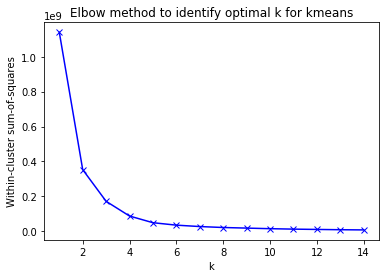

In [41]:
%matplotlib inline

inertia = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0).fit(dm_features)
    inertia.append(kmeans.inertia_)
    
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum-of-squares')
plt.title('Elbow method to identify optimal k for kmeans')
plt.show()

Using the <b>elbow method</b>, the <b>optimal number of clusters is 4</b>.

In [42]:
# set number of clusters
OPTIMAL_N_CLUSTERS = 4

# run k-means clustering
kmeans = KMeans(n_clusters=OPTIMAL_N_CLUSTERS, random_state=0).fit(dm_features)

munich_cluster = dm_adj.merge(top_venues, on='Postcode')
munich_cluster.insert(1, 'Cluster', kmeans.labels_)

munich_cluster.head()


,Postcode,Cluster,Borough,Lon,Lat,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults,1_MFV,2_MFV,3_MFV,4_MFV,5_MFV,6_MFV,7_MFV,8_MFV,9_MFV,10_MFV
0,80331,3,Altstadt-Lehel,11.570982,48.135276,6708.000000,26.100000,2000.000000,2052.380952,1723.492063,2583.492063,464.444444,100.317460,43.174603,9.523810,German Restaurant,Café,Department Store,Church,Bavarian Restaurant,Gourmet Shop,Cocktail Bar,Hotel,Plaza,Steakhouse
1,80333,0,"Altstadt-Lehel,Maxvorstadt",11.568539,48.144916,9334.000000,25.750000,1850.000000,3249.562569,2132.443706,3840.118125,638.733850,124.926172,54.261720,12.436323,Café,Italian Restaurant,Art Museum,History Museum,Hotel,Steakhouse,Plaza,Bar,German Restaurant,Burrito Place
2,80335,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Maxvorstadt,Schwanthalerhöhe",11.554155,48.143586,11192.250000,28.350000,1725.000000,3793.456076,2702.240189,4293.514816,769.807472,163.175372,73.850502,18.187584,Hotel,Indie Movie Theater,Ice Cream Shop,Plaza,Bar,Thai Restaurant,Circus,Hotel Bar,Beer Garden,Trattoria/Osteria
3,80336,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Sendling",11.552987,48.132914,9615.666667,27.133333,1815.333333,3109.044689,2444.148947,3616.245547,687.769360,148.077286,62.852925,15.317735,Hotel,Supermarket,Middle Eastern Restaurant,Cocktail Bar,Bavarian Restaurant,Theater,BBQ Joint,Irish Pub,Zoo,English Restaurant
4,80337,0,"Ludwigsvorstadt-Isarvorstadt,Sendling",11.558362,48.125945,11069.500000,27.650000,1723.000000,3637.376557,2804.477388,4132.622289,799.431818,171.957199,72.692086,18.214698,Bavarian Restaurant,Café,Vietnamese Restaurant,Bistro,Nightclub,German Restaurant,Caucasian Restaurant,Beer Bar,Seafood Restaurant,Italian Restaurant


Plot the results

In [43]:
     
map_munich_cluster = folium.Map(location=[latitude, longitude], zoom_start=11)

# generating a Choropleth with the population density in Munich
cluster_choropleth = folium.Choropleth(
    geo_data=munich_geo,
    data=munich_cluster,
    columns=['Postcode', 'Cluster'],
    key_on='feature.properties.plz',
    fill_color='Set3', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    threshold_scale=[0, 1, 2, 3, 4],
    highlight=True,
    legend_name='Munich Clusters, DE'
).add_to(map_munich_cluster)

cluster_choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['note'])
)

map_munich_cluster

##### Cluster 0

This cluster is characterized by high income and high concentration of 1 households. The density of residents is also very high.

In [44]:
c0 = munich_cluster.loc[munich_cluster['Cluster'] == 0]
c0
#High income num of 1 households >> others . very high density

,Postcode,Cluster,Borough,Lon,Lat,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults,1_MFV,2_MFV,3_MFV,4_MFV,5_MFV,6_MFV,7_MFV,8_MFV,9_MFV,10_MFV
1,80333,0,"Altstadt-Lehel,Maxvorstadt",11.568539,48.144916,9334.000000,25.750000,1850.000000,3249.562569,2132.443706,3840.118125,638.733850,124.926172,54.261720,12.436323,Café,Italian Restaurant,Art Museum,History Museum,Hotel,Steakhouse,Plaza,Bar,German Restaurant,Burrito Place
2,80335,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Maxvorstadt,Schwanthalerhöhe",11.554155,48.143586,11192.250000,28.350000,1725.000000,3793.456076,2702.240189,4293.514816,769.807472,163.175372,73.850502,18.187584,Hotel,Indie Movie Theater,Ice Cream Shop,Plaza,Bar,Thai Restaurant,Circus,Hotel Bar,Beer Garden,Trattoria/Osteria
3,80336,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Sendling",11.552987,48.132914,9615.666667,27.133333,1815.333333,3109.044689,2444.148947,3616.245547,687.769360,148.077286,62.852925,15.317735,Hotel,Supermarket,Middle Eastern Restaurant,Cocktail Bar,Bavarian Restaurant,Theater,BBQ Joint,Irish Pub,Zoo,English Restaurant
4,80337,0,"Ludwigsvorstadt-Isarvorstadt,Sendling",11.558362,48.125945,11069.500000,27.650000,1723.000000,3637.376557,2804.477388,4132.622289,799.431818,171.957199,72.692086,18.214698,Bavarian Restaurant,Café,Vietnamese Restaurant,Bistro,Nightclub,German Restaurant,Caucasian Restaurant,Beer Bar,Seafood Restaurant,Italian Restaurant
6,80469,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Sendling",11.571161,48.128202,9615.666667,27.133333,1815.333333,3109.044689,2444.148947,3616.245547,687.769360,148.077286,62.852925,15.317735,Café,Italian Restaurant,Ice Cream Shop,Restaurant,Bookstore,Coffee Shop,Bistro,Jazz Club,Bar,Pizza Place
8,80539,0,"Altstadt-Lehel,Maxvorstadt",11.581699,48.145137,9334.000000,25.750000,1850.000000,3249.562569,2132.443706,3840.118125,638.733850,124.926172,54.261720,12.436323,Plaza,Café,Opera House,Cocktail Bar,Hotel,Steakhouse,Garden,Theater,River,Dance Studio
10,80636,0,"Maxvorstadt,Neuhausen-Nymphenburg",11.542170,48.151145,9805.500000,24.850000,1650.000000,3340.994091,2240.372345,3787.643975,689.857871,138.942500,63.115937,15.149244,Italian Restaurant,Hotel,Café,Vietnamese Restaurant,German Restaurant,Drugstore,Steakhouse,Music Venue,Indie Movie Theater,Organic Grocery
14,80686,0,"Laim,Sendling-Westpark",11.510826,48.130153,9165.000000,28.700000,1675.000000,2661.266758,2243.074895,2969.366137,692.873273,150.583567,70.290016,19.015295,Ice Cream Shop,German Restaurant,Mobile Phone Shop,Doner Restaurant,Burger Joint,Sandwich Place,Hotel,Greek Restaurant,Drugstore,Caucasian Restaurant
21,80801,0,"Maxvorstadt,Schwabing-Freimann,Schwabing-West",11.578006,48.158766,10234.000000,25.800000,1699.666667,3446.557177,2289.492658,3855.108044,716.885000,145.893133,67.703856,17.091043,Italian Restaurant,Breakfast Spot,Café,German Restaurant,Ice Cream Shop,Vietnamese Restaurant,Greek Restaurant,Asian Restaurant,Trattoria/Osteria,Plaza
23,80803,0,"Schwabing-Freimann,Schwabing-West",11.580387,48.164255,9371.000000,26.000000,1699.500000,2946.463673,2163.541313,3234.289974,668.815872,144.072258,68.881365,17.962147,Pizza Place,Trattoria/Osteria,Café,Ethiopian Restaurant,Supermarket,Bakery,Thai Restaurant,Indian Restaurant,Coffee Shop,Grocery Store


##### Cluster 1

Fast foods and dining services exceed restaurants. That suggests the presence of a customer base that prefers drive-thru and carry-out restaurants. The data suggests also high presence of families. The density of the population for km^2 is in mid-lower range (25-50 quantile). The average income is in a low-mid range (25 to 50 quantile). High concentration of bus stops suggests a population that need quick access to cheap transportation.

In [45]:
c1 = munich_cluster.loc[munich_cluster['Cluster'] == 1]
c1
#Family and higher concentration of foreigners. mid income. fast food and dining services exceed the restaurants

,Postcode,Cluster,Borough,Lon,Lat,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults,1_MFV,2_MFV,3_MFV,4_MFV,5_MFV,6_MFV,7_MFV,8_MFV,9_MFV,10_MFV
25,80805,1,Schwabing-Freimann,11.604967,48.172659,3036.0,29.30,1699.0,953.019088,705.064277,849.084534,198.870277,48.694975,24.230619,7.713284,Hotel,Bakery,Restaurant,Bavarian Restaurant,Tennis Court,Beach,Beer Garden,Café,Pool,Sports Bar
26,80807,1,"Milbertshofen-Am Hart,Schwabing-Freimann",11.585487,48.184058,4316.5,35.05,1564.0,1339.773330,1020.602183,1184.564622,286.841994,71.851213,35.028872,11.718043,Hotel,Drugstore,Clothing Store,Café,Supermarket,Cocktail Bar,Burger Joint,Italian Restaurant,Thai Restaurant,Gastropub
28,80933,1,Feldmoching-Hasenbergl,11.557400,48.216188,2135.0,32.40,1388.0,549.516240,566.689703,457.740152,147.753974,41.430546,22.494817,7.049067,Supermarket,Drugstore,Gas Station,Zoo,Donut Shop,Fish Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fair
29,80935,1,Feldmoching-Hasenbergl,11.553322,48.198750,2135.0,32.40,1388.0,549.516240,566.689703,457.740152,147.753974,41.430546,22.494817,7.049067,Drugstore,Café,Supermarket,Fried Chicken Joint,Greek Restaurant,Bus Stop,Bakery,Fish Market,Fast Food Restaurant,Farmers Market
31,80939,1,"Milbertshofen-Am Hart,Schwabing-Freimann",11.616969,48.203990,4316.5,35.05,1564.0,1339.773330,1020.602183,1184.564622,286.841994,71.851213,35.028872,11.718043,Lounge,Greek Restaurant,Soccer Stadium,Fast Food Restaurant,Big Box Store,Concert Hall,Supermarket,Pet Store,Rock Climbing Spot,Sports Bar
32,80992,1,Moosach,11.522268,48.175412,4888.0,31.50,1600.0,1359.603246,1241.388638,1301.893598,368.169522,87.105500,44.274121,12.533814,Supermarket,Bakery,Drugstore,German Restaurant,Hotel,Trattoria/Osteria,Fried Chicken Joint,Taverna,Motel,Gastropub
33,80993,1,Moosach,11.519224,48.186442,4888.0,31.50,1600.0,1359.603246,1241.388638,1301.893598,368.169522,87.105500,44.274121,12.533814,Supermarket,Clothing Store,Greek Restaurant,Electronics Store,Bakery,Café,Italian Restaurant,Donut Shop,Drugstore,Juice Bar
34,80995,1,"Allach-Untermenzing,Feldmoching-Hasenbergl",11.514590,48.216248,2147.0,28.30,1527.5,541.327700,584.898249,438.417002,154.556599,42.301033,23.286243,6.598967,Bus Stop,Ice Cream Shop,Bakery,German Restaurant,Supermarket,Greek Restaurant,Lake,American Restaurant,Falafel Restaurant,Fair
35,80997,1,"Allach-Untermenzing,Moosach",11.482864,48.190779,3523.5,27.85,1633.5,946.371202,922.247717,860.493724,264.764373,65.138511,34.175895,9.341341,Bus Stop,Supermarket,Hardware Store,Turkish Restaurant,Bakery,Doner Restaurant,Italian Restaurant,Athletics & Sports,Hotel,Gym / Fitness Center
36,80999,1,Allach-Untermenzing,11.451909,48.191239,2159.0,24.20,1667.0,533.139159,603.106796,419.093851,161.359223,43.171521,24.077670,6.148867,Supermarket,Bavarian Restaurant,Drugstore,Bakery,German Restaurant,Soccer Field,Food & Drink Shop,Bus Stop,Sporting Goods Shop,Beer Garden


##### Cluster 2

The cluster is characterized by very high residents density. Income are in the mid range. The concentration of restaurants is very high.

In [46]:
c2 = munich_cluster.loc[munich_cluster['Cluster'] == 2]
c2
#very high density. Income mid. very high concentration of restaurants.

,Postcode,Cluster,Borough,Lon,Lat,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults,1_MFV,2_MFV,3_MFV,4_MFV,5_MFV,6_MFV,7_MFV,8_MFV,9_MFV,10_MFV
5,80339,2,Schwanthalerhöhe,11.539114,48.135440,14367.0,33.50,1400.0,4641.062802,3638.164251,4957.004831,1002.898551,228.985507,112.560386,29.468599,Café,Italian Restaurant,Asian Restaurant,Hotel,Bar,Ice Cream Shop,Pub,Modern Greek Restaurant,Japanese Restaurant,Beer Garden
17,80796,2,Schwabing-West,11.570176,48.163243,15706.0,22.70,1700.0,4939.908257,3622.018349,5619.495413,1138.761468,239.449541,113.532110,28.211009,Bakery,Coffee Shop,Austrian Restaurant,Beer Store,Bar,Italian Restaurant,Tapas Restaurant,Bistro,Restaurant,Thai Restaurant
18,80797,2,"Maxvorstadt,Schwabing-West",11.557444,48.162663,13833.0,24.05,1700.0,4693.326221,3081.706849,5358.119799,975.892362,194.492213,89.440474,21.779923,Gym / Fitness Center,Hotel,Coworking Space,Pool,Movie Theater,Mediterranean Restaurant,Sports Bar,Italian Restaurant,Taverna,Bakery
19,80798,2,"Maxvorstadt,Schwabing-West",11.565880,48.155446,13833.0,24.05,1700.0,4693.326221,3081.706849,5358.119799,975.892362,194.492213,89.440474,21.779923,Spanish Restaurant,Grilled Meat Restaurant,Bar,Italian Restaurant,Bavarian Restaurant,Ramen Restaurant,Café,Taverna,Fair,Ethiopian Restaurant
20,80799,2,"Maxvorstadt,Schwabing-West",11.575899,48.152036,13833.0,24.05,1700.0,4693.326221,3081.706849,5358.119799,975.892362,194.492213,89.440474,21.779923,Café,Bar,Poke Place,Donut Shop,Bakery,Bagel Shop,Breakfast Spot,Italian Restaurant,Restaurant,French Restaurant
53,81541,2,"Au-Haidhausen,Obergiesing-Fasangarten",11.586275,48.120314,12013.0,27.30,1650.0,3686.707487,3052.800517,4045.500530,861.925397,201.092036,92.530574,23.091423,Café,Italian Restaurant,Pub,Fair,Turkish Restaurant,Greek Restaurant,Bistro,Gym / Fitness Center,Falafel Restaurant,Donut Shop
58,81667,2,Au-Haidhausen,11.601472,48.129084,14541.0,23.50,1700.0,4449.289100,3764.691943,5016.350711,1040.284360,240.995261,113.033175,26.777251,Café,Italian Restaurant,Plaza,German Restaurant,Beer Garden,Ice Cream Shop,Bar,Rock Club,Pizza Place,Bavarian Restaurant


##### Cluster 3

The cluster is characterized by the highest concentration of foreigners. Income are in the mid-high range. Residents density is in the mid range. There is a large offer for restaurants also of foreign cuisines.

In [47]:
c3 = munich_cluster.loc[munich_cluster['Cluster'] == 3]
c3
#Highest concentration of foreigners. Income mid-high. mid density. large offer for restaurants also foreign ones

,Postcode,Cluster,Borough,Lon,Lat,Density,Foreigners,Income,Age_28_44,Age_45_64,1HH,2HH_Adults,3HH_Adults,4HH_Adults,5HH_Adults,1_MFV,2_MFV,3_MFV,4_MFV,5_MFV,6_MFV,7_MFV,8_MFV,9_MFV,10_MFV
0,80331,3,Altstadt-Lehel,11.570982,48.135276,6708.000000,26.100000,2000.000000,2052.380952,1723.492063,2583.492063,464.444444,100.317460,43.174603,9.523810,German Restaurant,Café,Department Store,Church,Bavarian Restaurant,Gourmet Shop,Cocktail Bar,Hotel,Plaza,Steakhouse
7,80538,3,"Altstadt-Lehel,Schwabing-Freimann",11.591116,48.148062,4872.000000,27.700000,1849.500000,1502.700020,1214.278170,1716.288299,331.657361,74.506217,33.702611,8.618547,Surf Spot,Italian Restaurant,Cocktail Bar,Trattoria/Osteria,Monument / Landmark,Snack Place,Pastry Shop,Beer Garden,German Restaurant,Performing Arts Venue
9,80634,3,Neuhausen-Nymphenburg,11.530619,48.148105,7651.000000,24.300000,1600.000000,2235.243997,1939.349342,2478.543765,566.692486,128.350116,60.883036,14.949651,German Restaurant,Plaza,Ice Cream Shop,Greek Restaurant,Spanish Restaurant,Pizza Place,Bar,Taverna,Fast Food Restaurant,Sushi Restaurant
11,80637,3,"Moosach,Neuhausen-Nymphenburg",11.537167,48.162250,6269.500000,27.900000,1600.000000,1797.423622,1590.368990,1890.218681,467.431004,107.727808,52.578579,13.741733,Café,Organic Grocery,Restaurant,Sushi Restaurant,Italian Restaurant,Gastropub,German Restaurant,Beer Garden,Trattoria/Osteria,Pool
12,80638,3,"Moosach,Neuhausen-Nymphenburg",11.496242,48.160220,6269.500000,27.900000,1600.000000,1797.423622,1590.368990,1890.218681,467.431004,107.727808,52.578579,13.741733,Palace,History Museum,Theater,Café,Bus Stop,Science Museum,Botanical Garden,Steakhouse,Supermarket,Fountain
13,80639,3,Neuhausen-Nymphenburg,11.513475,48.151402,7651.000000,24.300000,1600.000000,2235.243997,1939.349342,2478.543765,566.692486,128.350116,60.883036,14.949651,Italian Restaurant,Hotel,Bakery,Gymnastics Gym,Indian Restaurant,Music Venue,Canal,Restaurant,Café,Rock Club
15,80687,3,"Laim,Pasing-Obermenzing",11.506022,48.142176,7610.500000,25.700000,1738.500000,2130.507476,1936.498711,2363.215902,574.853640,127.447843,61.400985,15.621355,Supermarket,Bakery,Gym / Fitness Center,Drugstore,Auto Garage,Restaurant,Doner Restaurant,Movie Theater,Sushi Restaurant,Chinese Restaurant
16,80689,3,"Hadern,Laim,Pasing-Obermenzing",11.483789,48.132145,6877.000000,26.233333,1697.333333,1892.211057,1742.589886,2003.532221,520.365189,117.611650,57.781423,14.644172,Greek Restaurant,Supermarket,Ice Cream Shop,Bus Stop,Drugstore,Gastropub,Bakery,American Restaurant,Falafel Restaurant,Fair
22,80802,3,"Maxvorstadt,Schwabing-Freimann",11.591308,48.159984,7498.000000,27.350000,1699.500000,2699.881637,1623.229813,2972.914360,505.946766,99.114929,44.789728,11.531061,Bar,Italian Restaurant,German Restaurant,Sushi Restaurant,Plaza,Gym,Taco Place,Frozen Yogurt Shop,Steakhouse,Beer Garden
30,80937,3,Milbertshofen-Am Hart,11.574086,48.209153,5597.000000,40.800000,1429.000000,1726.527571,1336.140089,1520.044709,374.813711,95.007452,45.827124,15.722802,Food & Drink Shop,Clothing Store,Supermarket,German Restaurant,Mexican Restaurant,Zoo,Drugstore,Fish Market,Fast Food Restaurant,Farmers Market


### Scoring the properties and evaluate neighborhoods in clusters

In the following the neighborhoods will be scored reflecting the relative importance of their features for the business idea. The following criteria will be evaluated:

<ol>
    <li>Alignment with external environment</li>
    <li>Alignment of internal differentiating capabilities with right external market position</li>
    <li>Degree of rivalry</li>
</ol>

From the above considerations, it results that the clusters with label 0, 2, and 3 are the most suitable for the service subject of this study. In detail, neighborhoods in such clusters host residents with high-end income and an adult population in the age of interest.

Cluster 1 groups neighborhoods in which fast foods and dining services exceed restaurants. That suggests the presence of a customer base that prefers drive-thru and carry-out restaurants. The density of the population for km^2 is in mid-lower range (25th-50th percentile). The average pre-capita income is also in a low-mid range (25th to 50th percentile), confirmed by high presence of bus stops. Indeed Public bus routes attract low-income residents because they offer an affordable means of transportation. (https://chicagopolicyreview.org/2018/01/08/how-public-bus-routes-can-deconcentrate-poverty-and-promote-equity/) The characteristic of the cluster suggests low appetite for fine dining services. 


#### Degree of rivalry

It should be considered that the degree of rivalry in the cluster 2 is greater than in the others. The population density is also 50% higher than the one in the oder clusters, while the incomes are in the mid range.

In the following the data is shaped to evaluate the degree of rivalry considering the culinary trends. According to a study of Civey (2018) presented in Figure 1, the Italian cuisine is the most favorite one in Germany, preferred by the 33,8% of the population, followed by German (30.10%), Thai/Vietnamese (8.3%), Greek (6.9%), Chinese (4.7%), and Japanese (2.8%) ones. 

In [48]:
restaurants_col = ['Postcode'] + [x for x in vd.columns if re.match('.*Restaurant.*|.*Bar.*|.*Taverna.*|.*Osteria.*', x) is not None ]
all_restaurants = vd.loc[:,restaurants_col].groupby('Postcode', as_index=False).sum()
all_restaurants.head()

,Postcode,Afghan Restaurant,American Restaurant,Asian Restaurant,Austrian Restaurant,Bar,Bavarian Restaurant,Beer Bar,Bosnian Restaurant,Caucasian Restaurant,Chinese Restaurant,Cocktail Bar,Cretan Restaurant,Doner Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Grilled Meat Restaurant,Hookah Bar,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Ramen Restaurant,Restaurant,Schnitzel Restaurant,Seafood Restaurant,Spanish Restaurant,Sports Bar,Sushi Restaurant,Tapas Restaurant,Taverna,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,80331,0,0,0,0,1,3,0,0,0,0,2,0,0,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,80333,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,80335,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,80336,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,80337,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,2,0


(74, 54)

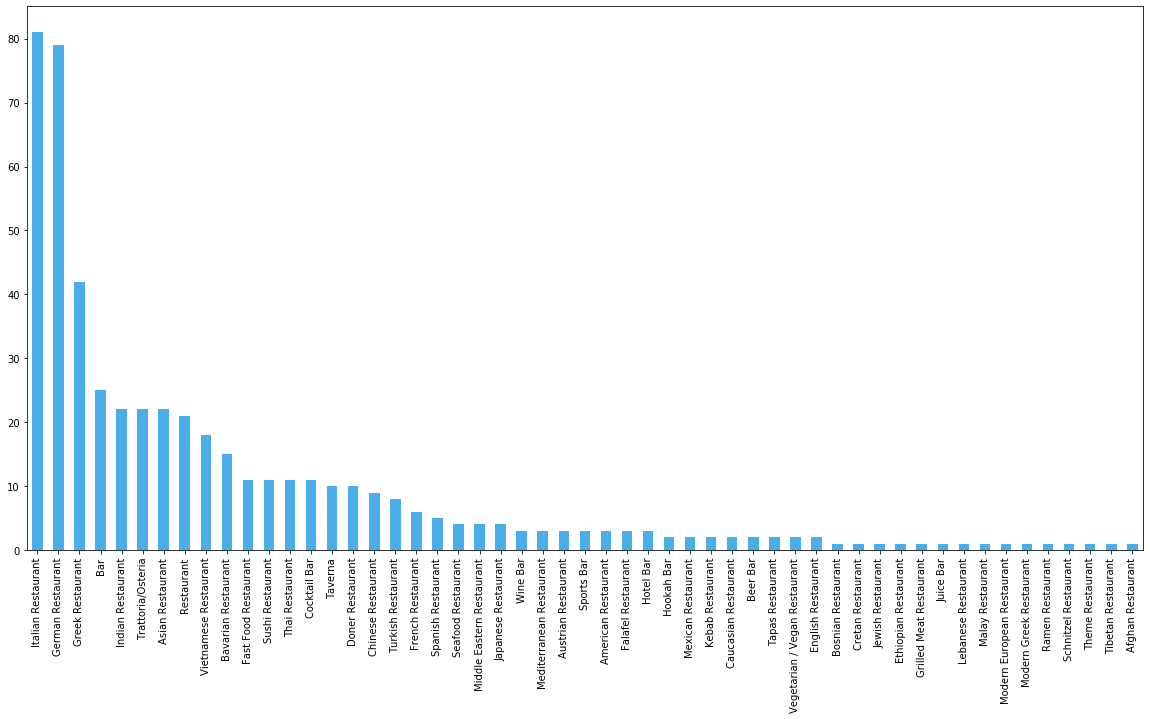

In [49]:
all_restaurants.loc[:,'Afghan Restaurant':].sum().sort_values(ascending=False).plot(kind='bar', figsize=(20,10), color='#4BAEEA')
all_restaurants.shape

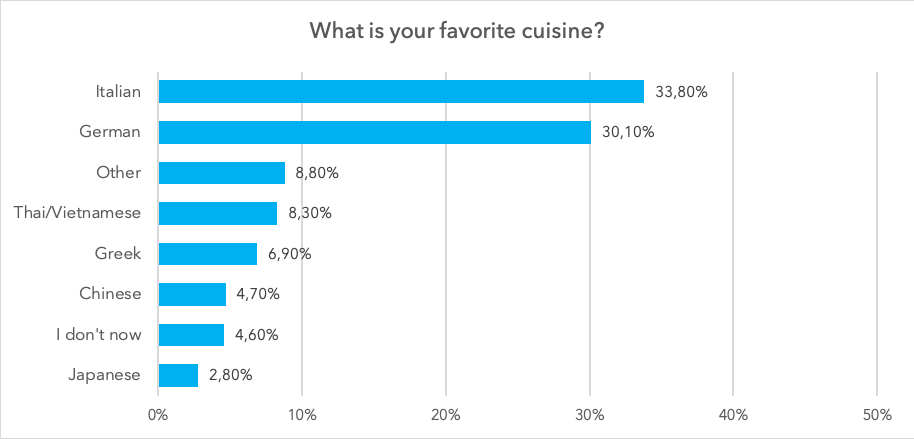

The scoring of the degree of rivalry is calculated in a range 1 to 5. First of all, the main culinary trends are scored by position. The Thai/Vietnamese, Chinese, and Japanese cuisines are considered a single category as the some categories returned by Foursquare cannot be uniquely assigned.

In [50]:
rest_cat = {
    'Italian Restaurants': {
        'labels': [ 'Italian Restaurant', 'Trattoria/Osteria' ],
        'weight': 5
    },
    'German Restaurants': {
        'labels': [ 'Austrian Restaurant', 'Bavarian Restaurant', 'Beer Bar', 'German Restaurant', 'Schnitzel Restaurant'],
        'weight': 4
    },
    'Asian Restaurants': {
        'labels': [ 'Asian Restaurant', 'Chinese Restaurant',  'Japanese Restaurant', 'Sushi Restaurant', 'Thai Restaurant', 'Vietnamese Restaurant'],
        'weight': 4
    },
    'Greek Restaurants': {
        'labels': [ 'Cretan Restaurant', 'Greek Restaurant', 'Taverna' ],
        'weight': 3
    },
    'Others': {
        'labels': None,
        'weight': 3
    }
}

cr_labels = []
restaurants = pd.DataFrame(all_restaurants.loc[:,'Postcode'])

for key,value in rest_cat.items():
    if value['labels'] is not None:
        restaurants[key] = all_restaurants.loc[:,value['labels']].sum(axis=1)
        cr_labels.append(value['labels'])

other_labels = [x for x in all_restaurants.columns.tolist() if x not in cr_labels]
restaurants['Others'] = all_restaurants.loc[:,other_labels].sum(axis=1)

(74, 6)

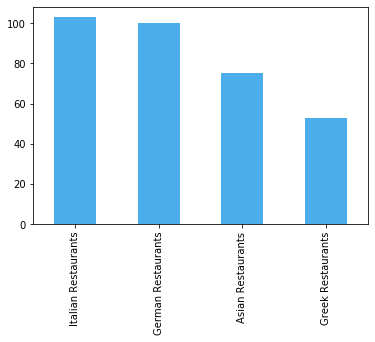

In [51]:
restaurants.loc[:,'Italian Restaurants':'Greek Restaurants'].sum().plot(kind='bar', color='#4BAEEA')
restaurants.shape

In [52]:
restaurants = restaurants.merge(zc.loc[:,['Postcode','Surface']].drop_duplicates(), on='Postcode')
restaurants = restaurants.merge(munich_cluster.loc[:,['Postcode','Age_28_44','Age_45_64']], on='Postcode')
restaurants.shape

(74, 9)

From the plot it results that overall, Italian restaurants are the most frequent ones. That strengthens the need for an accurate location selection.

Calculate the number of restaurants pro-habitant and normalize the values using a min-max scaler. The final score is computed using the above specified weights.

In [53]:
restaurants.loc[:,'Italian Restaurants':'Others'] = restaurants.loc[:,'Italian Restaurants':'Others'].div((restaurants['Age_28_44'] + restaurants['Age_45_64'])*restaurants['Surface'], axis=0)
restaurants.drop(['Surface'], axis=1, inplace=True)

mmscaler = MinMaxScaler()

restaurants.loc[:,'Italian Restaurants':'Others'] = mmscaler.fit_transform(restaurants.loc[:,'Italian Restaurants':'Others'])

for key,value in rest_cat.items():
    restaurants[key] = restaurants[key]*value['weight']

# A penalty is assigned to areas with higher rivalry score
restaurants.insert(1, 'RivalryScore', -1*restaurants.loc[:,'Italian Restaurants':'Others'].mean(axis=1))
restaurants.head()

,Postcode,RivalryScore,Italian Restaurants,German Restaurants,Asian Restaurants,Greek Restaurants,Others,Age_28_44,Age_45_64
0,80331,-1.392832,0.000000,4.000000,0.000000,0.0,2.964160,2052.380952,1723.492063
1,80333,-0.720043,2.074327,0.194380,0.414865,0.0,0.916642,3249.562569,2132.443706
2,80335,-0.279635,0.409764,0.153592,0.327811,0.0,0.507007,3793.456076,2702.240189
3,80336,-0.093113,0.000000,0.192804,0.000000,0.0,0.272762,3109.044689,2444.148947
4,80337,-0.890474,0.675086,1.265215,1.080137,0.0,1.431932,3637.376557,2804.477388


#### Demographic features and income

The remaining features are scored given the considerations on residents age and households provided above.

In [54]:
f_scores = {
    'DemographicScore': [
        {'column': 'Age_28_44', 'weight': 5},
        {'column': 'Age_45_64', 'weight': 5},
        {'column': '1HH', 'weight': 5},
        {'column': '2HH_Adults', 'weight': 5},
        {'column': '3HH_Adults', 'weight': 4},
        {'column': '4HH_Adults', 'weight': 3},
        {'column': '5HH_Adults', 'weight': 2}
    ],
    'IncomeScore': [
        {'column': 'Income', 'weight': 5}
    ]
}

In [55]:
score_master_data = ['Postcode','Cluster','Borough']

f_score_cols = [e['column'] for v in f_scores.values() for e in v ]

munich_score = munich_cluster.loc[:,score_master_data + f_score_cols]

#Normalize the values using the min-max scaler
munich_score.loc[:,f_score_cols] = mmscaler.fit_transform(munich_score.loc[:,f_score_cols])

# The score is calculated as weighted average
for scoreKey, criteria in f_scores.items():
    munich_score[scoreKey] = 0
    
    for c in criteria:
        munich_score[scoreKey] += c['weight'] * munich_score[c['column']] / len(criteria)

munich_score = munich_score[score_master_data+list(f_scores.keys())]

munich_score = pd.merge(left=munich_score, right=restaurants.loc[:,'Postcode':'RivalryScore'], how='left', on='Postcode')

munich_score.head()

,Postcode,Cluster,Borough,DemographicScore,IncomeScore,RivalryScore
0,80331,3,Altstadt-Lehel,1.402777,5.000000,-1.392832
1,80333,0,"Altstadt-Lehel,Maxvorstadt",2.129334,3.774510,-0.720043
2,80335,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Maxvorstadt,Schwanthalerhöhe",2.757668,2.753268,-0.279635
3,80336,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Sendling",2.316748,3.491285,-0.093113
4,80337,0,"Ludwigsvorstadt-Isarvorstadt,Sendling",2.773733,2.736928,-0.890474


#### Overall score

In [56]:
#Select only the relevant clusters and compute the total score
munich_score = munich_score[munich_score['Cluster'].isin([0, 2, 3])]

munich_score['TotalScore'] = munich_score.loc[:, [x for x in munich_score.columns if 'Score' in x]].sum(axis=1)
munich_score.head()

,Postcode,Cluster,Borough,DemographicScore,IncomeScore,RivalryScore,TotalScore
0,80331,3,Altstadt-Lehel,1.402777,5.000000,-1.392832,5.009945
1,80333,0,"Altstadt-Lehel,Maxvorstadt",2.129334,3.774510,-0.720043,5.183801
2,80335,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Maxvorstadt,Schwanthalerhöhe",2.757668,2.753268,-0.279635,5.231301
3,80336,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Sendling",2.316748,3.491285,-0.093113,5.714920
4,80337,0,"Ludwigsvorstadt-Isarvorstadt,Sendling",2.773733,2.736928,-0.890474,4.620187


Filter areas with total score greather than or equal to 3.5 in order to show the top performing neighborhoods.

In [57]:
munich_score = munich_score[munich_score['TotalScore']>=3.5]

print('Identified {} neighborhoods with score >= 3.5'.format(munich_score.shape[0]))

munich_score.head()

Identified 32 neighborhoods with score >= 3.5


,Postcode,Cluster,Borough,DemographicScore,IncomeScore,RivalryScore,TotalScore
0,80331,3,Altstadt-Lehel,1.402777,5.000000,-1.392832,5.009945
1,80333,0,"Altstadt-Lehel,Maxvorstadt",2.129334,3.774510,-0.720043,5.183801
2,80335,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Maxvorstadt,Schwanthalerhöhe",2.757668,2.753268,-0.279635,5.231301
3,80336,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Sendling",2.316748,3.491285,-0.093113,5.714920
4,80337,0,"Ludwigsvorstadt-Isarvorstadt,Sendling",2.773733,2.736928,-0.890474,4.620187


In [58]:
munich_score.describe()

,Cluster,DemographicScore,IncomeScore,RivalryScore,TotalScore
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,1.031250,2.409483,2.661654,-0.446533,4.624604
std,1.307161,0.717853,0.724828,0.345081,0.737082
min,0.000000,0.867416,1.441993,-1.392832,3.598225
25%,0.000000,2.129334,2.140523,-0.725615,3.900680
50%,0.000000,2.251955,2.549020,-0.329111,4.627746
75%,2.000000,2.683286,2.887051,-0.204804,5.184987
max,3.000000,4.092665,5.000000,-0.013337,5.899352


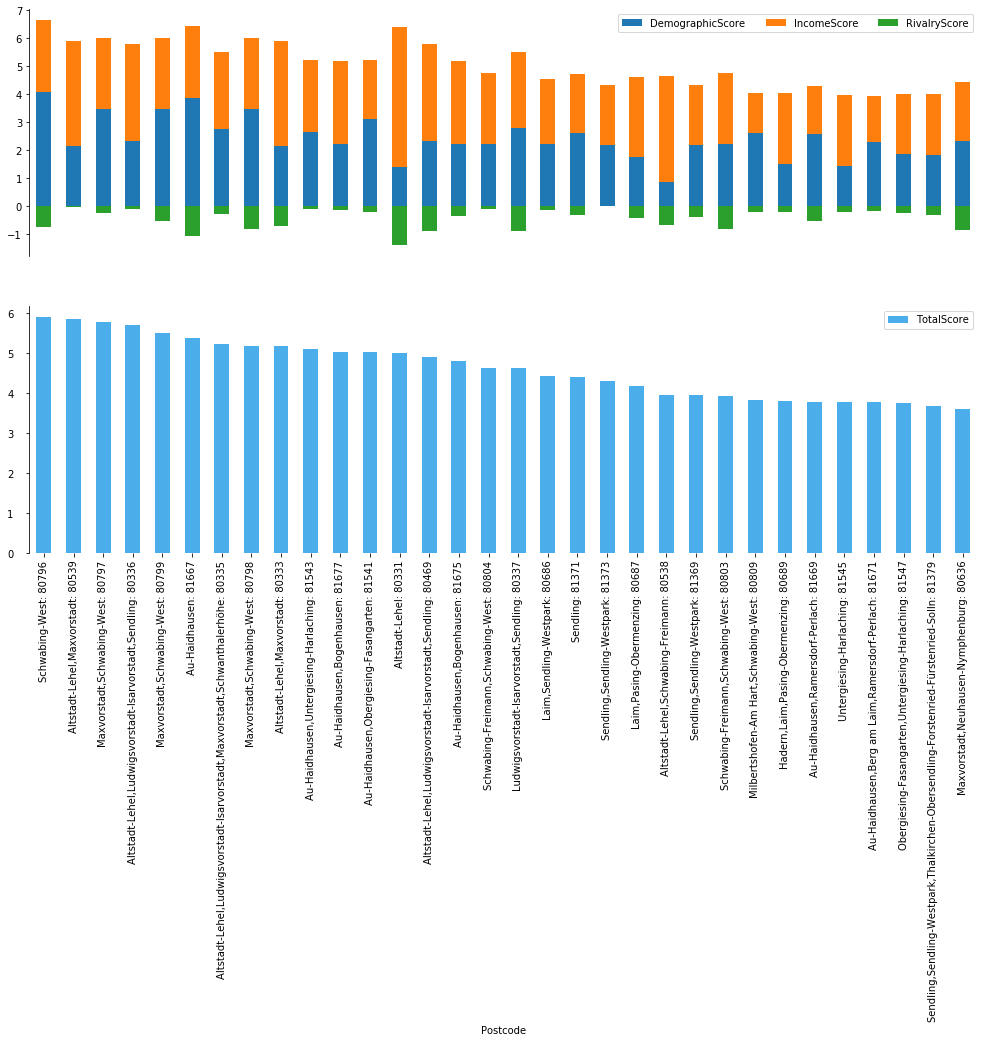

In [59]:
bar_score = munich_score.copy()
bar_score.loc[:,['DemographicScore','IncomeScore','RivalryScore']].div(3)

bar_score['Postcode'] = bar_score['Borough'] + ': ' + bar_score['Postcode']

fig, spax = plt.subplots(nrows=2,ncols=1)

ax = bar_score.sort_values(by='TotalScore', ascending=False) \
                     .drop(columns=['TotalScore','Cluster']) \
                     .plot(x='Postcode', kind='bar', figsize=(17,15), stacked=True, ax=spax[0])

ax.axes.get_xaxis().set_visible(False)
ax.legend(ncol=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax = bar_score.loc[:,['Postcode','TotalScore']].sort_values(by='TotalScore', ascending=False) \
         .plot(x='Postcode', kind='bar', figsize=(17,10), color='#4BAEEA', ax=spax[1])

ax.tick_params(axis="y", pad=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Fix plot saving
ax.get_figure().savefig('neighborhoods_score.png', bbox_inches='tight')


In [60]:
map_munich_score = folium.Map(location=[latitude, longitude], zoom_start=11)

# generating a Choropleth with the score of the neighborhoods
score_choropleth = folium.Choropleth(
    geo_data=munich_geo,
    data=munich_score[munich_score['TotalScore']>5],
    columns=['Postcode', 'TotalScore'],
    key_on='feature.properties.plz',
    fill_color='PuRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    nan_fill_color='grey',
    legend_name='Selected Neighborhoods, DE'
).add_to(map_munich_score)

score_choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['note'])
)

map_munich_score

In [61]:
munich_score[munich_score['TotalScore']>5].sort_values(by='TotalScore',ascending=False)

,Postcode,Cluster,Borough,DemographicScore,IncomeScore,RivalryScore,TotalScore
17,80796,2,Schwabing-West,4.092665,2.549020,-0.742333,5.899352
8,80539,0,"Altstadt-Lehel,Maxvorstadt",2.129334,3.774510,-0.035620,5.868224
18,80797,2,"Maxvorstadt,Schwabing-West",3.474278,2.549020,-0.237699,5.785599
3,80336,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Sendling",2.316748,3.491285,-0.093113,5.714920
20,80799,2,"Maxvorstadt,Schwabing-West",3.474278,2.549020,-0.524013,5.499285
58,81667,2,Au-Haidhausen,3.879060,2.549020,-1.057920,5.370160
2,80335,0,"Altstadt-Lehel,Ludwigsvorstadt-Isarvorstadt,Maxvorstadt,Schwanthalerhöhe",2.757668,2.753268,-0.279635,5.231301
19,80798,2,"Maxvorstadt,Schwabing-West",3.474278,2.549020,-0.834751,5.188546
1,80333,0,"Altstadt-Lehel,Maxvorstadt",2.129334,3.774510,-0.720043,5.183801
54,81543,0,"Au-Haidhausen,Untergiesing-Harlaching",2.658492,2.549020,-0.103229,5.104282
